In [79]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [80]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [81]:
# 4. Chia train test (70% train, 30% test)
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [82]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [83]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [84]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [85]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [86]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 [==============================] - 9s 164ms/step - loss: 0.0511 - val_loss: 0.0083
Epoch 2/100
14/14 [==============================] - 1s 67ms/step - loss: 0.0091 - val_loss: 0.0028
Epoch 3/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 4/100
14/14 [==============================] - 1s 67ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 5/100
14/14 [==============================] - 1s 67ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 6/100
14/14 [==============================] - 1s 67ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 7/100
14/14 [==============================] - 1s 69ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 8/100
14/14 [==============================] - 1s 68ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 9/100
14/14 [==============================] - 1s 101ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 10/100
14/14 [==============================] - 2s 116ms/step - loss: 0.0030 - val_loss: 0.0

In [87]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

12/12 [==============================] - 2s 12ms/step


In [88]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [89]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 416.54138118640435
MAPE trên tập test là: 2.2523588072004235 %
MSLE trên tập test là: 0.0009904409341795273


In [90]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

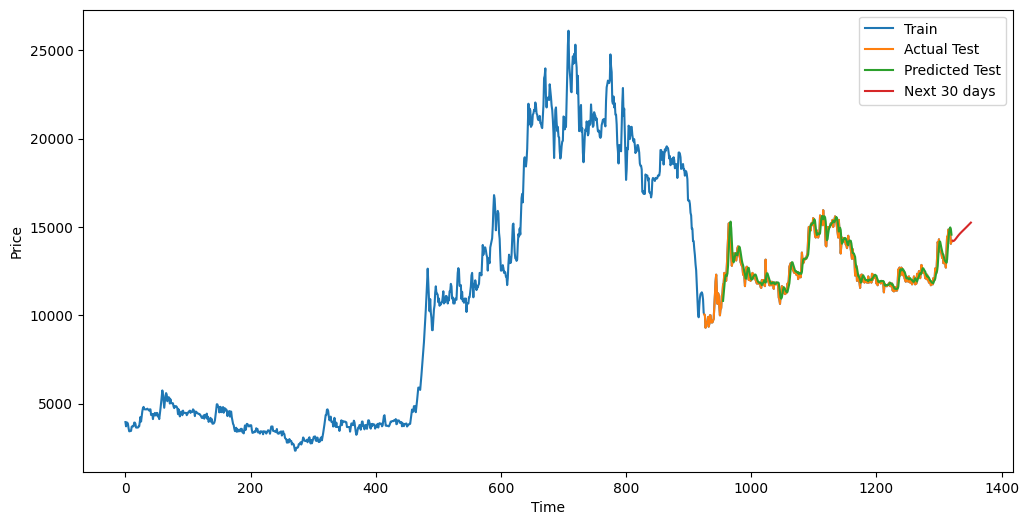

In [91]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# (Split 8/2)

In [92]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [93]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [94]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [95]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [96]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [97]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [98]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [99]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 9s 222ms/step - loss: 0.0423 - val_loss: 0.0043
Epoch 2/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0070 - val_loss: 0.0035
Epoch 3/100
17/17 [==============================] - 1s 64ms/step - loss: 0.0033 - val_loss: 9.5850e-04
Epoch 4/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0027 - val_loss: 8.8303e-04
Epoch 5/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0026 - val_loss: 8.5686e-04
Epoch 6/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0026 - val_loss: 8.4110e-04
Epoch 7/100
17/17 [==============================] - 1s 65ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 8/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 9/100
17/17 [==============================] - 1s 61ms/step - loss: 0.0026 - val_loss: 8.4969e-04
Epoch 10/100
17/17 [==============================] - 1s 60ms/step - loss: 0.00

In [100]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

8/8 [==============================] - 1s 16ms/step


In [101]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [102]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 345.98665034077976
MAPE trên tập test là: 1.86811721867976 %
MSLE trên tập test là: 0.000653952441933535


In [103]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

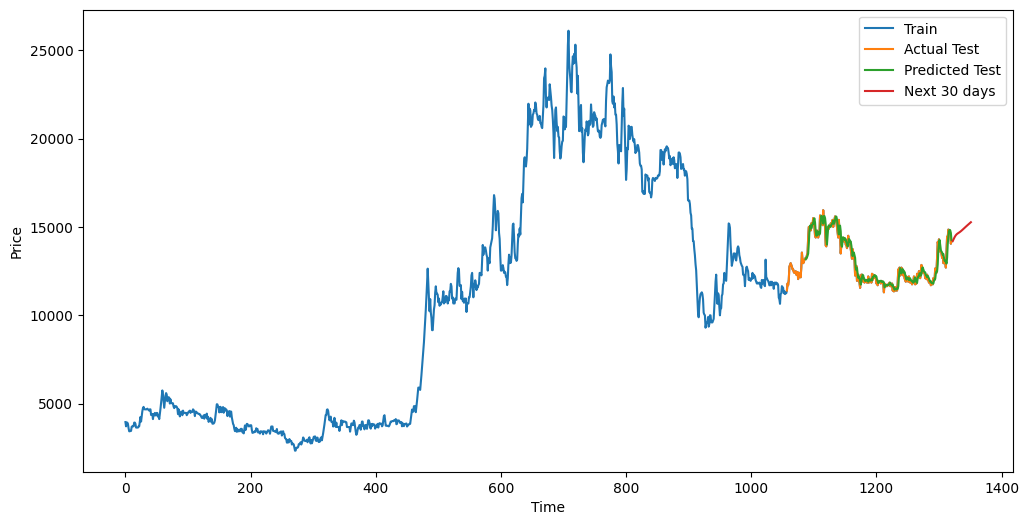

In [104]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# (Split 9/1)

In [105]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('SGT.csv', index_col='time', parse_dates=True)
data=data.drop(columns=['open', 'high', 'low', 'volume'])
data = data.reset_index(drop=True)
df1 = data.reset_index()['close']

In [106]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [107]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [108]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [109]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [110]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [111]:
# 8. Define LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [112]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
19/19 [==============================] - 10s 175ms/step - loss: 0.0653 - val_loss: 0.0083
Epoch 2/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 3/100
19/19 [==============================] - 1s 59ms/step - loss: 0.0035 - val_loss: 6.6581e-04
Epoch 4/100
19/19 [==============================] - 1s 60ms/step - loss: 0.0029 - val_loss: 6.3857e-04
Epoch 5/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0027 - val_loss: 8.0734e-04
Epoch 6/100
19/19 [==============================] - 1s 58ms/step - loss: 0.0026 - val_loss: 7.7523e-04
Epoch 7/100
19/19 [==============================] - 1s 58ms/step - loss: 0.0025 - val_loss: 6.6664e-04
Epoch 8/100
19/19 [==============================] - 1s 57ms/step - loss: 0.0025 - val_loss: 7.2754e-04
Epoch 9/100
19/19 [==============================] - 1s 62ms/step - loss: 0.0022 - val_loss: 6.9519e-04
Epoch 10/100
19/19 [==============================] - 2s 85ms/step - l

In [113]:
# 10. Dự báo dữ liệu test
y_pred = model.predict(X_test)

4/4 [==============================] - 1s 11ms/step


In [114]:
# 11. Inverse transform dự báo và dữ liệu thực tế
y_pred_new = scaler.inverse_transform(y_pred)
y_test_new = scaler.inverse_transform(y_test.reshape(-1, 1))

In [115]:
from sklearn.metrics import mean_squared_log_error

# Tính toán RMSE, MAE và MAPE trên tập test
test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 335.6458468737788
MAPE trên tập test là: 2.093754310340668 %
MSLE trên tập test là: 0.00068226904039196


In [116]:
# 13. Dự báo 30 ngày tiếp theo
x_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
i = 0
while i < 30:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

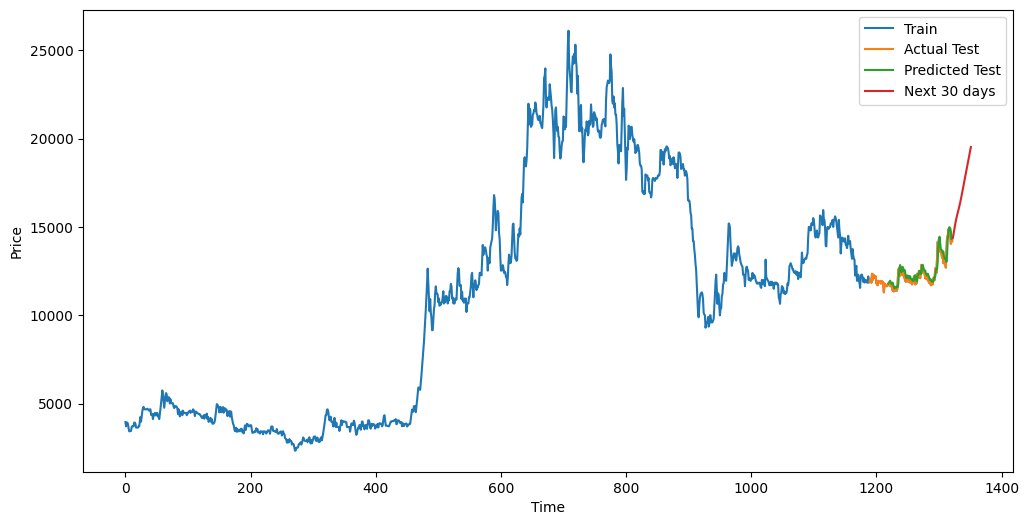

In [117]:
# 14. Vẽ hình
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df1), label='Train')
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Actual Test')
test_pred_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + test_size - 1, step=1)
plt.plot(test_pred_index, scaler.inverse_transform(y_pred), label='Predicted Test')
predict_data_index = pd.RangeIndex(start=len(df1), stop=len(df1) + 30, step=1)
plt.plot(predict_data_index, scaler.inverse_transform(lst_output), label='Next 30 days')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()